![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRjFm003pSAOtHmnUm7e--Xquwo90Hp5-U_3wSZrkChGz4tQYWZ)
# Introduction to Machine Learning
## Innopolis University 
### Week 7: Ensemble Learning
1. Decision trees
* Pruning
2. Ensemble Learning
* Bagging
* Random Forests
* AdaBoost


## Decision trees

Let's make the experiments with conditions under which we finish spliting nodes. 

Here you can experiment with *DecisionTreeRegressor* paramethers. Uncomment paramethers set one by one and adjust the value using regression visualization.

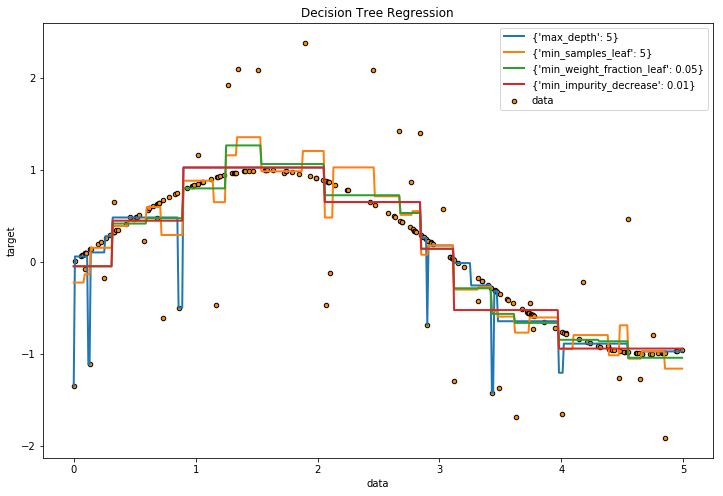

In [0]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(1)
size = 200
X = np.sort(5 * rng.rand(size, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(size//5))

# Fit regression model

trees_paramethers=[{"max_depth":5},
                   {"min_samples_leaf":5},
                   {"min_weight_fraction_leaf":0.05},
                   {"min_impurity_decrease":0.01}
                  ]
classifiers = [DecisionTreeRegressor(**params) for params in trees_paramethers]
for clf in classifiers:
    clf.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
predictions = [clf.predict(X_test) for clf in classifiers]

# Plot the results

plt.figure(figsize=(12,8))
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")

for params, pred in zip(trees_paramethers, predictions):
    plt.plot(X_test, pred, label=str(params), linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()



## Ensemble learning
We will compare, how ensemble of decision trees could improve classification accuracy. 

Let's start from uploading MNIST dataset.

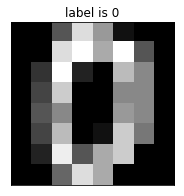

In [0]:
from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.stats import mode

digits = load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)


plt.figure(1, figsize=(3, 3))
plt.imshow(X[0].reshape((8,8)), cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title(f"label is {y[0]}")
plt.show()

### Single decision tree

Train on a single decision tree with max depth 10.

In [0]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
pred = tree.predict(X_test)
tree_score = accuracy_score(y_test, pred)
print(tree_score)

0.867003367003367


You should get ~ 0.85
accuracy score.

### Bagging

Let's train a hundred classifiers.

In [0]:
n_trees = 100

classifiers = []
for i in range(n_trees):
    base = DecisionTreeClassifier()
    base.fit(X_train, y_train)
    classifiers.append(base)

base_pred = np.zeros((X_test.shape[0], n_trees), dtype="int")
for i in range(n_trees):
    base_pred[:,i] = classifiers[i].predict(X_test)

print(base_pred)

pred = mode(base_pred, axis=1)[0].ravel()
acc = accuracy_score(y_test, pred)
print(acc)

[[8 8 8 ... 3 3 8]
 [8 8 8 ... 8 8 8]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [2 2 2 ... 2 2 2]]
0.8821548821548821


Now it's 0.88. You can see, that our classifiers return very similar results. By the way, why the base classifiers are not identical at all?

### Random forest

In random forest base classifiers will be much less correlated.

At first, let's implement a bootstrap sampling.

In [0]:
def bootstrap(X, y):
    ind = np.random.randint(0, X.shape[0], X.shape[0])
    return X[ind,:], y[ind]
  
  
np.random.seed(0)
a = np.array(range(12)).reshape(4,3)
b = np.array(range(4))
bootstrap(a, b)

(array([[ 0,  1,  2],
        [ 9, 10, 11],
        [ 3,  4,  5],
        [ 0,  1,  2]]), array([0, 3, 1, 0]))

You will get

(array([[ 0,  1,  2],
        [ 9, 10, 11],
        [ 3,  4,  5],
        [ 0,  1,  2]]), array([0, 3, 1, 0]))
       
Now let's build a set of decision trees, each of them is trained on a bootstrap sampling from X and $\sqrt d$ features.

In [0]:
classifiers = []
for i in range(n_trees):
    base = DecisionTreeClassifier(max_features="sqrt")
    bs_X, bs_y = bootstrap(X_train, y_train)
    base.fit(bs_X, bs_y)
    classifiers.append(base)

base_pred = np.zeros((n_trees, X_test.shape[0]), dtype="int")
for i in range(n_trees):
    base_pred[i,:] = classifiers[i].predict(X_test)

pred = mode(base_pred, axis=0)[0].ravel()
acc = accuracy_score(y_test, pred)
print(acc)

0.9814814814814815


And now we got 0.97 accuracy.

## Boosting

For simplicity let's make a binary classification problem.

In [0]:
y_train_b = (y_train == 2 ) * 2 - 1
y_test_b = (y_test == 2 ) * 2 - 1

Now let's train a boosting model.

We will have sample weights and tree weights. Initially all sample weights are equal. After that we will increase weight for complicated samples.

Tree weight $w$ is computed using weighted error or $1 - accuracy$

$w_t = \frac12 log(\frac{1-weighted\_error_t}{weighted\_error_t})$ for each base classifier.

For correct samples weights will be decreased $e^w$ times, and for incorrect classified samples increased  $e^w$ times. After this changes we normalize weight.

In [0]:
n_trees = 10
tree_weights = np.zeros(n_trees)
classifiers = []
train_samples = X_train.shape[0]
sample_weights = np.ones(train_samples) / train_samples
for i in range(n_trees):
    clf = DecisionTreeClassifier(min_samples_leaf=3)
    clf.fit(X_train, y_train_b, sample_weight=sample_weights)
    pred = clf.predict(X_train)
    acc = accuracy_score(y_train_b, pred, sample_weight=sample_weights)
    w = 0.5 * np.log(acc / (1 - acc))
    tree_weights[i] = w
    classifiers.append(clf)
    # update weights
    for j in range(train_samples):
        if pred[j] != y[j]:
            sample_weights[j] = sample_weights[j] * np.exp(w)
        else:
            sample_weights[j] = sample_weights[j] * np.exp((-w))
    # normalize them
    sample_weights = sample_weights / np.sum(sample_weights)

Use trees voting to calculate final predictions. Because we have a binary classification

$\hat{y} = sign(\sum_{t=1}^{T}(w_t f_t(x)))$

In [0]:
n_test = X_test.shape[0]
base_predictions = np.zeros((n_test, 10))


pred = np.zeros(n_test)
for t in range(n_trees):
    pred += classifiers[t].predict(X_test) * tree_weights[t]
for i in range(n_test):
    pred[i] = 1 if pred[i] > 0 else -1


acc = accuracy_score(y_test_b, pred)
print(acc)

0.9696969696969697


Result accuracy is 0.97